In [6]:
from pathlib import Path
import pandas as pd
pd.set_option("display.max_columns", None)  # Display all columns
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import numpy as np
import shap
shap.initjs()
import xgboost as xgb
import dill as pickle

In [7]:
save_data_dir = Path(Path.cwd().parent, "data", "interim")
X_train = pd.read_pickle(Path(save_data_dir, "X_train.pkl"))
y_train = pd.read_pickle(Path(save_data_dir, "y_train.pkl"))
X_test = pd.read_pickle(Path(save_data_dir, "X_test.pkl"))
y_test = pd.read_pickle(Path(save_data_dir, "y_test.pkl"))

save_trained_model_dir = Path(Path.cwd().parent, "models")
xgb_model = "XGBoost - default params.pkl"
with open(Path(save_trained_model_dir, xgb_model), "rb") as f:
    XGBoostDefault = pickle.load(f)

# Explainability 

In order to understand why some customers are likely to churn, we can investigate the feature importance of the various input features. 
This can be done with both XGBoost directly, and using third party tools. 

When using XGBoost we can select from either "weight","gain", or "cover" to choose how to explain the feature importance. 
Unfortunately these the most importance features are not consistence across the various critria, as seen below:

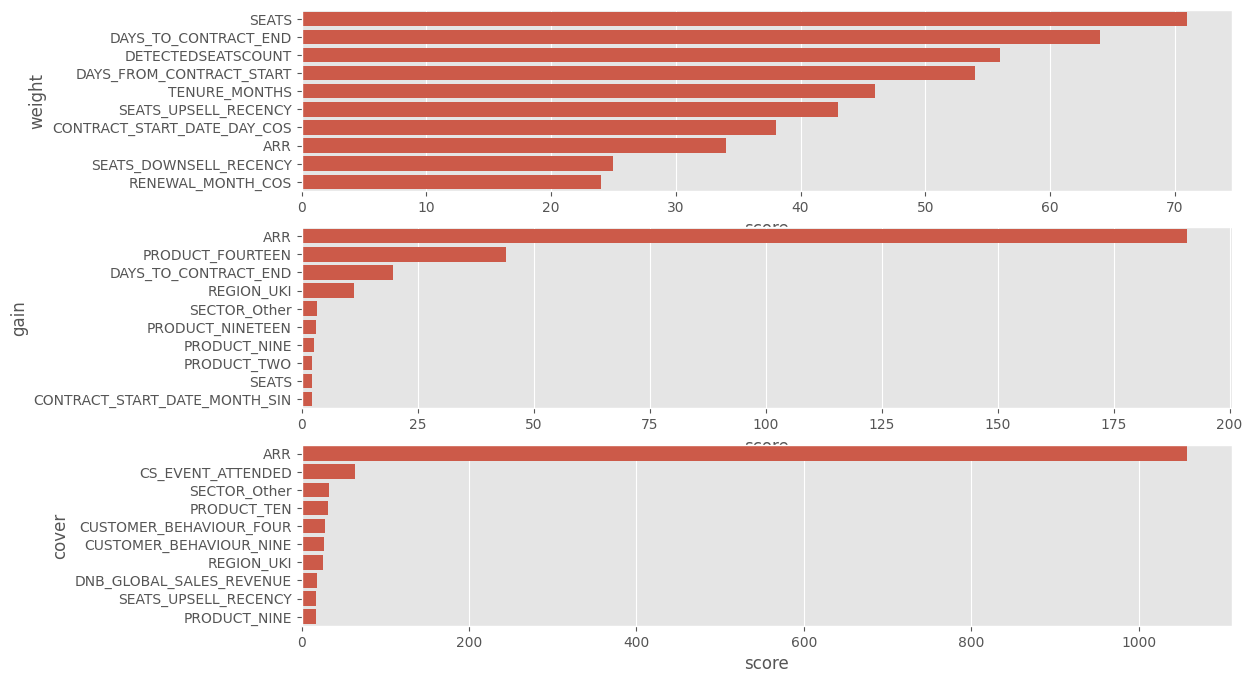

In [3]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
axes = np.ravel(ax)
for i, criteria in enumerate(["weight", "gain", "cover"]):
    feature_important = XGBoostDefault.fitted_clf.get_booster().get_score(
        importance_type=criteria
    )
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    feature_importance_df = pd.DataFrame(
        data=values, index=keys, columns=["score"]
    ).sort_values(by="score", ascending=False)
    top_n_features = feature_importance_df.nlargest(10, columns="score")

    sns.barplot(data=top_n_features, x="score", y=top_n_features.index, ax=axes[i])
    axes[i].set_ylabel(criteria)

In order to get a better understanding, I'll also use SHAP (SHapley Additive exPlanations) to get a second opinion on importance. 

In [8]:
explainer = shap.TreeExplainer(XGBoostDefault.fitted_clf)
shap_values = explainer.shap_values(X_train)

[12:19:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[12:20:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


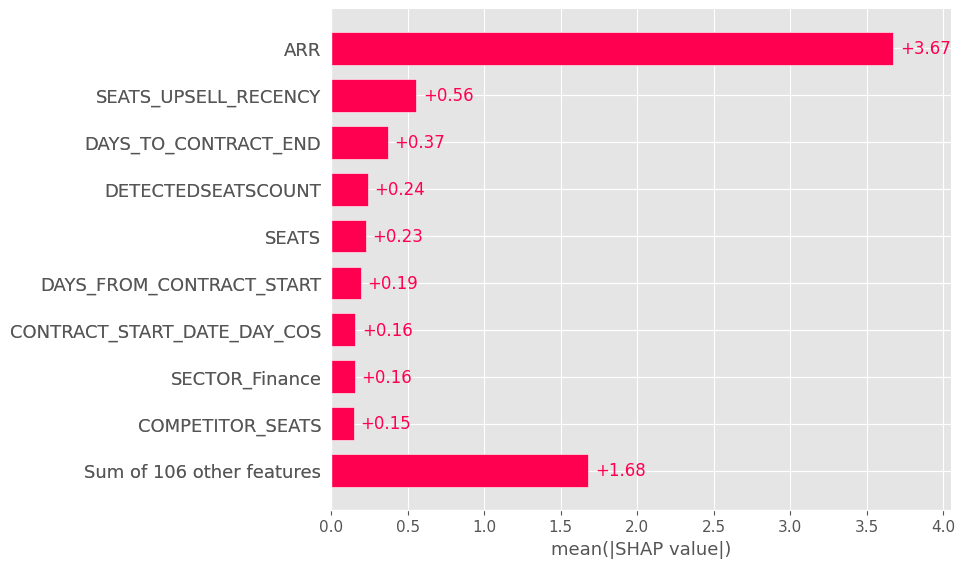

In [9]:
explainer = shap.TreeExplainer(XGBoostDefault.fitted_clf)
shap_values = explainer(X_train)

shap.plots.bar(shap_values)

Using SHAP we can see that ARR (Annual Recurring Revenue) is the feature most heavily affecting the model predictions. This aligns with the outputs seen from XGboost for 'gain' and 'cover'. 

In [21]:
len(shap_values)

80000

The SHAP Package also allows us to investigate the importance of features for each individual prediction, for example the first three examples:

Information on interpreting these plots can be found here:

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html


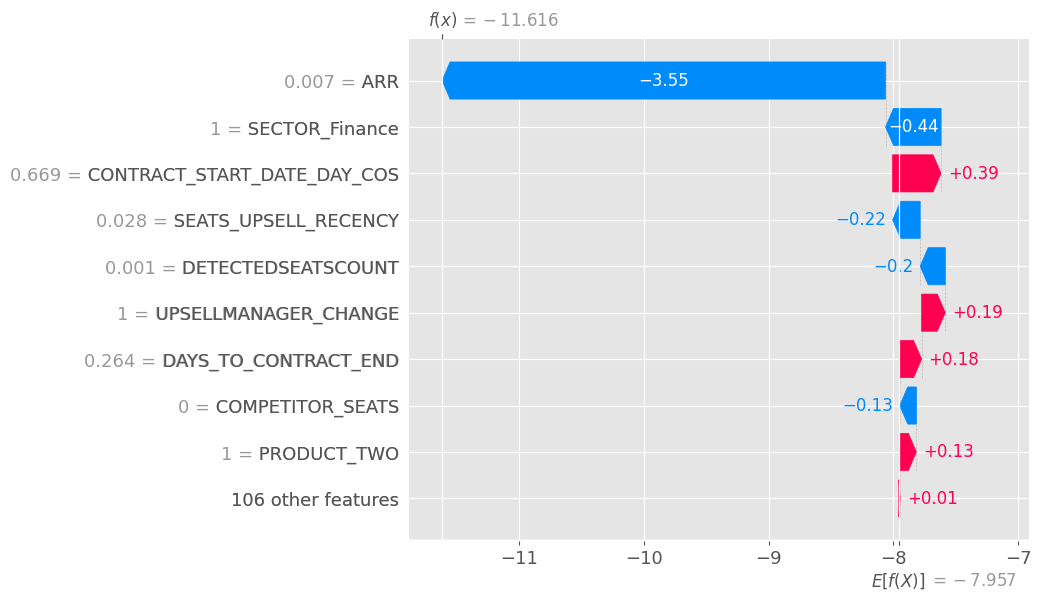

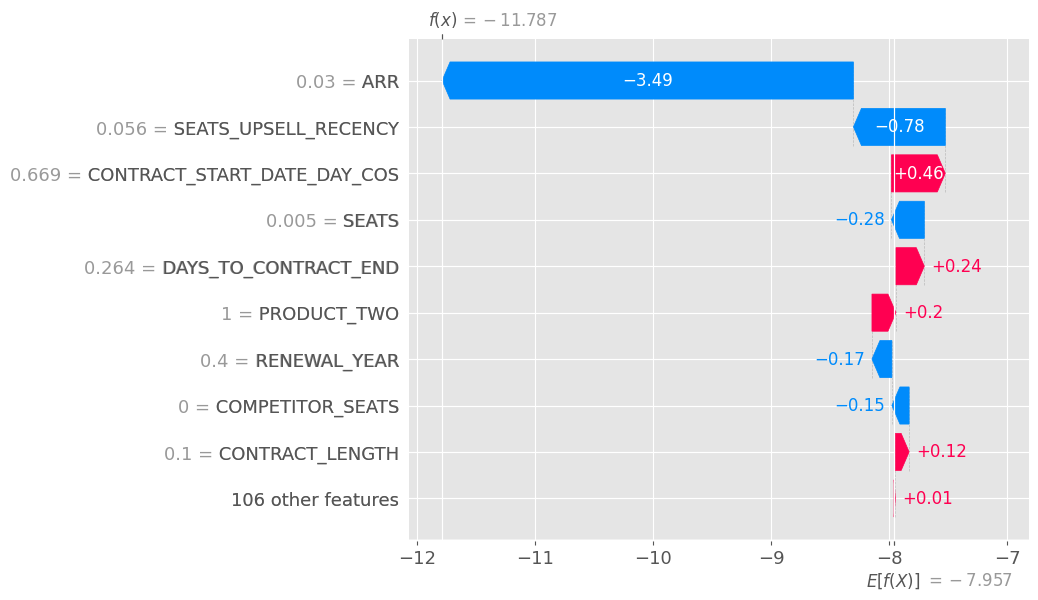

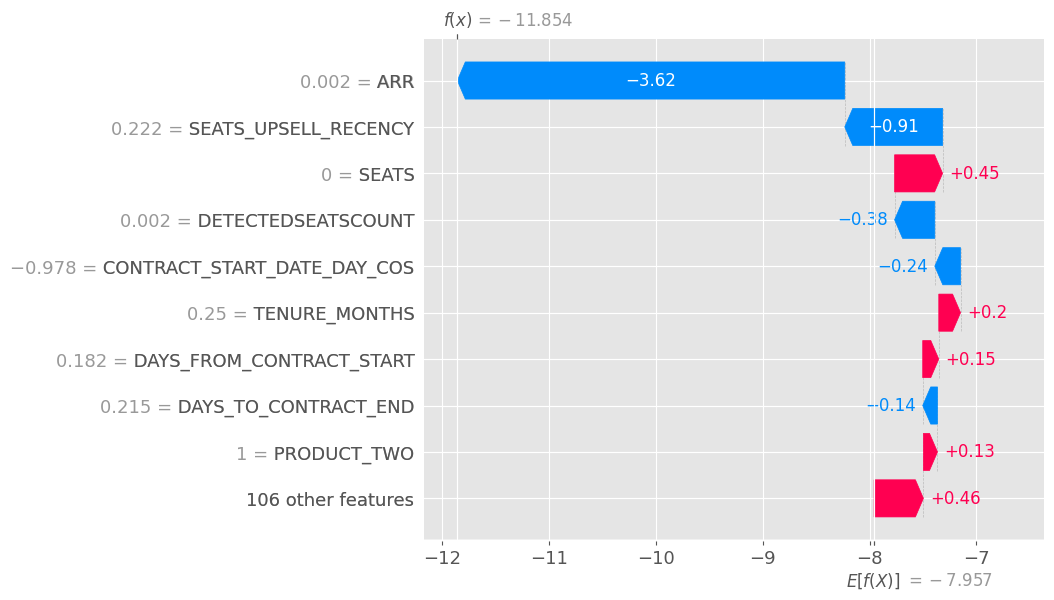

In [22]:
shap.waterfall_plot(shap_values[0])
shap.waterfall_plot(shap_values[1])
shap.waterfall_plot(shap_values[2])